### Tensorflow Hub
<a href="https://tfhub.dev/">Tensroflow Hub</a>란 재사용 가능한 머신러닝 모듈 라이브러리 이다.  
즉, Tensorflow Hub은 머신러닝 모델의 재사용 가능한 부분을 게시, 검색, 소비하기 위한 라이브러리 이다. 모듈은 해다 가중치 및 자산이 포함되어 있으며 전이 학습이라는 프로세스에서 여러 작업 간에 재사용할 수 있는 TEnsorflow 그래프의 자체 포함된 조각이다. 전이 학습을 통해 다음과 같은 작업이 가능하다.
- 소규모 데이터세트를 사용한 모델 학습: 이미 가중치가 Training되어있고, 자식와 같은 목표의 Model을 찾으면 학습은 거의 하지 않아도 된다.
- 일반화 개선: Training되어있는 Model들은 일반적으로 모을수 있는 Dataset보다 훨씬 많은 Dataset으로서 Training되어있기 때문이다.
- 학습속도 개선: 전이학습을 통해서 Training되어있는 모델을 사용하기 때문이다.

이러한 TensorflowHub은 다음과 같이 설치될 수 있다.  
**참고사항**: tensorflow_hub Version설치 Guide에서는 0.4.0을 설치하라고 나와있지만 0.5.0 이상이여야지 예제가 활성화되고 돌아간다.(<a href="https://github.com/tensorflow/hub/issues/388">GitHub Issue</a>)

In [1]:
!pip install "tensorflow_hub>=0.5.0"
!pip install "tf-nightly"

#### 필요한 Library Import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import PIL.Image as Image
import time
# Tensorflow Hub 라이브러리 가져오기
import tensorflow_hub as hub

### An ImageNet classifier
Tensorflow Hub의 Model을 그대로 가져와서 Image를 어떻게 예측하는지 알아본다. 즉, 과연 Tensorflow Hub에 올려놓은 Model이 잘 작동하는 지 확인하는 것이 목표이다.  
<a href="https://tfhub.dev/s?module-type=image-classification&q=tf2">TensorFlow 2 compatible image classifier URL </a>에서 Mobilenet을 URL로서 불러와 사용한다.  
**Keras에서 Hub의 Model을 Layer에 추가하기 위하여 <code>hub.KerasLayer()</code>로서 정의한다.**

In [3]:
#가져올 Model의 URL을 정의한다.
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

#Hyperparameter: Image의 Size정의
IMAGE_SHAPE = (224, 224)

#Keras에서 가져온 Model을 통하여 Layer를 구성한다.(Clolor Image를 Input으로 받음)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

#### Prepare a Dataset
해당 링크에서 하나의 Image를 가져와서 Model에 넣을 Input Size로 변형시킨 뒤 Image를 확인한다.

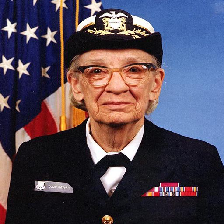

In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

#### Run it on a single Image
Model이 Input Image를 어떻게 Classify하는지 살펴본다.  
각각의 과정은 다음과 같이 진행된다.  
1. 0 ~ 1 사이의 값으로서 정규화
2. Batch로서 넣기 위하여 Dimension 증가
3. 1001개의 Class(1000개의 Class + Background) 중 Tensorflow Model은 몇 번째 Class로 분류하는지 확인한다.


In [5]:
grace_hopper = np.array(grace_hopper)/255.0
print(grace_hopper.shape)

result = classifier.predict(grace_hopper[np.newaxis, ...])
print(result.shape)

predicted_class = np.argmax(result[0], axis=-1)
print(predicted_class)

(224, 224, 3)
(1, 1001)
653


#### Decode the Prediction
혀재 1001개의 Class중에 653번째 Class라고 Image를 분류하였다.  
Image를 어떻게 분류하였는지 확인하기 위하여 Index마다의 Class값을 알아야 한다.  
밑에서 다운로드 받는 "ImageNetLabels.txt"의 내용을 살펴보면 다음과 같다.  

background  
tench  
goldfish  
great white shark  
tiger shark  
hammerhead  
electric ray  
....  

즉 아래의 Visuzlization한 결과는 어떤 Class로 분류했는지에 대한 내용을 제목으로서 확인한 것 이다.

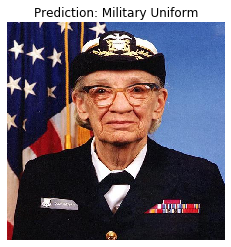

In [6]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

### Transfer learningwith Tensorflow Hub
<a href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=ko">Tensorflow 정식 홈페이지에서 Tensorflow Hub</a>의 예제를 따라하면서 Tensorflow Module Hub을 어떻게 Keras에서 전이학습을 통해 사용하는지 알아보는 것을 목표로 한다.  
홈페이지에서는 크게 다음과 같이 3가지를 목표로 두고 있다.  
1. How to use TensorFlow Hub with tf.keras.
2. How to do image classification using TensorFlow Hub.
3. How to do simple transfer learning.

<a href="https://wjddyd66.github.io/tnesorflow2.0/Tensorflow2.0(4)/#load-images">Load and preprocess Data2</a>에서 다룬 Dataset(daisy, dandelion, roses, sunflowers, tulips)을 분류하는 것을 목표로 한다.  
<br>

#### Dataset
1. 위의 링크에서와 마찬가지로 Dataset을 다운로드 받는다.
2. ImageDataGenerator를 사용하여 Image전처리에 사용한다.
3. Image의 값을 0~1사이로 정규화 한다.
4. Image를 Directory별로 분류한다. 즉, [Image Data, Label(One-Hot-Encoding)]로서 Data는 적용된다.
5. Model에 넣기 위하여 Batch형식으로 바꾼다.

위의 과정은 <code>tf.keras.preprocessing.image.ImageDataGenerator()</code>와 <code>image_generator.flow_from_directory()</code>로서 이루워진다.  
위의 과정이 이해되지 않으면 <a href="https://wjddyd66.github.io/tnesorflow2.0/Tensorflow2.0(4)/#load-images">Load and preprocess Data2</a>를 참조하자.  

**참조(ResourceExhaustedError)**  
현재 Training할 Dataset을 BatchSize를 위와같이 32로하였더니 GraphicCard가 감당하지 못한다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Tensorflow/39.png" height="250" width="400" /></div><br>
따라서 BatchSize를 5로서 줄인 뒤 Training결과를 확인하였다.

In [3]:
IMAGE_SHAPE = (224, 224)

data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), batch_size=5, target_size=IMAGE_SHAPE)

# Dataset 값 확인
for image_batch, label_batch in image_data:
    print("Image batch")
    print("-shape: ", image_batch.shape)
    print("-min: ",image_batch[0].min())
    print("-max: ",image_batch[0].max())
    print()
    print("Label batch")  
    print("-shape: ", label_batch.shape)
    print("-value: ",label_batch[0])
    break

Found 3670 images belonging to 5 classes.
Image batch
-shape:  (5, 224, 224, 3)
-min:  0.0
-max:  1.0

Label batch
-shape:  (5, 5)
-value:  [0. 1. 0. 0. 0.]


#### Run the classifier on a batch of images
위에서 사용한 ImageNet MobileNet을 Tranfer Learning을 하지않고 그냥 예측했을 때의 결과를 확인한다.

Model Result Shape (5, 1001) = (Batch,Class(1000+1(Background))

Model Result Label
['cardoon' 'cardoon' 'sea urchin' 'coil' 'bee']


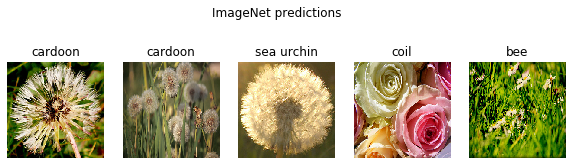

In [9]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

# Model 결과 확인
result_batch = classifier.predict(image_batch)
print('Model Result Shape',result_batch.shape,'= (Batch,Class(1000+1(Background))')
print()

# Model Label확인
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print('Model Result Label')
print(predicted_class_names)

# Model Label과 Image를 Mapping하여 Visualization한다.
plt.figure(figsize=(10,3))
plt.subplots_adjust(hspace=0.5)

for n in range(5):
    plt.subplot(1,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    
_ = plt.suptitle("ImageNet predictions")

#### Dwonload the headless model
Tensorflow Hub에서 위의 Model과 같은데 마지막 Layer가 없는, 즉 Classify하는 Softmax Layer가 없는 Model도 제공한다.  
**대부분의 제공되는 Model은 마지막 Layer가 없는 Model을 제공한다. 즉, 사용자의 입장에서는 Image로부터 Feature를 뽑아내는 과정은 미리 사전에 Training된 Model을 그대로 사용하고 마지막 Layer에 Softmax로서 다중분류 혹은 Sigmoid로서 이진분류만 Weight를 Update하여 Transfe Learning을 많이 진행한다.**

In [10]:
#마지막 Layer가 없는 Image Model Download
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

#이미 Training된 Model은 Feature추출에만 사용하고 따라서 Training중에 update되지 않게 설정한다.
feature_extractor_layer = hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
feature_extractor_layer.trainable = False

#Feature Extractor Layer의 출력 확인
feature_batch = feature_extractor_layer(image_batch)
print('Feature Extractor Layer Shape: ',feature_batch.shape,'(Batch,Feature)')
print()

#Feature Extractor Layer + Classify(데이터의 Label만큼 5개로 분류하는 다중분류)
#로서 Transfer Learning을 진행할 Model을 정의한다.
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

print('Model')
print(model.summary())
print()

predictions = model(image_batch)
print('Feature Prediction Shape: ',predictions.shape,'(Batch,Image Label(5:daisy, dandelion, roses, sunflowers, tulips))')

Feature Extractor Layer Shape:  (5, 1001) (Batch,Feature)



Model
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 5)                 5010      
Total params: 3,545,275
Trainable params: 5,010
Non-trainable params: 3,540,265
_________________________________________________________________
None

Feature Prediction Shape:  (5, 5) (Batch,Image Label(5:daisy, dandelion, roses, sunflowers, tulips))


#### Train the model
Model을 Training한다.  
<a href="https://wjddyd66.github.io/keras/Keras(5)/#%EC%BC%80%EB%9D%BC%EC%8A%A4-%EC%BD%9C%EB%B0%B1%EA%B3%BC-%ED%85%90%EC%84%9C%EB%B3%B4%EB%93%9C%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%9C-%EB%94%A5%EB%9F%AC%EB%8B%9D-%EB%AA%A8%EB%8D%B8-%EA%B2%80%EC%82%AC%EC%99%80-%EB%AA%A8%EB%8B%88%ED%84%B0%EB%A7%81">Keras의 Callback</a>을 사용하여 Training시 Loss와 Accuracy를 저장한다. (나중에 Visualization을 통하여 살펴보기 위하여)  

**참고**: <code>self.model.reset_metrics()</code>: Metrics를 초기화 한다. (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model?version=stable">Keras Model 설명서</a>)

In [11]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)


model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()
    
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
734/734 [==============================] - 77s 105ms/step - loss: 0.5316 - acc: 0.8000
Epoch 2/2
734/734 [==============================] - 77s 105ms/step - loss: 0.3018 - acc: 1.0000


#### Check Accuacy & Loss
Model을 Training하면서 정확도와 Loss를 각각 Training Steps에 따라 어떻게 변하였는지 확인한다.  
Smooth하게 표현하기 위해서 146개의 TrainingStep 의 평균으로서 Graph를 그리고 확인하였다.

Text(0.5, 1.0, 'Model Accuracy')

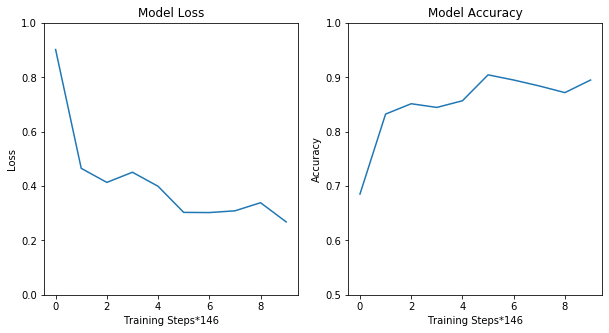

In [33]:
# Loss Smooth
len_loss = len(batch_stats_callback.batch_losses)
len_loss_10 = int(len_loss/10)
loss = []

for x in range(10):
    loss_sum=0
    for y in range(x*len_loss_10,(x+1)*len_loss_10):
        loss_sum+=batch_stats_callback.batch_losses[y]
    loss_sum/=(len_loss/10)
    loss.append(loss_sum)

# Accuracy Smooth
len_acc = len(batch_stats_callback.batch_acc)
len_acc_10 = int(len_acc/10)
acc = []

for x in range(10):
    acc_sum=0
    for y in range(x*len_acc_10,(x+1)*len_acc_10):
        acc_sum+=batch_stats_callback.batch_acc[y]
    acc_sum/=(len_acc/10)
    acc.append(acc_sum)
    
#Visualization
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.ylabel("Loss")
plt.xlabel("Training Steps*"+str(len_loss_10))
plt.ylim([0,1])
plt.plot(loss)
plt.title("Model Loss")

plt.subplot(122)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps*"+str(len_acc_10))
plt.ylim([0.5,1])
plt.plot(acc)
plt.title("Model Accuracy")

#### Check the prediction
실제 Transfer Learning한 Model의 Prediction을 Visualization하여 확인한다.  
다음과 같은 과정으로서 이루워진다.
1. Label의 Data는 One-Hot-Encoding으로서 되어있다. 따라서 이러한 Data를 Key값 즉, Label만을정렬하여거 가져와야 한다.
2. Model의 결과를 확인한다.
3. Label과 Prediction이 같으면 초록색으로 다르면 빨간색으로서 표시한다.



In [36]:
print(image_data.class_indices.items())
class_names_1 = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
print(class_names_1)

dict_items([('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)])
[('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)]


['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


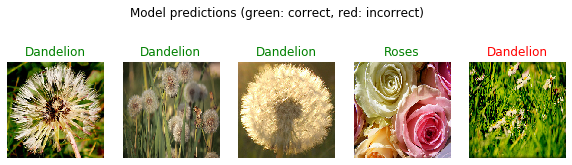

In [34]:
# One-Hot-Encoding으로서 표현된 Label을 Label만 가져온다.
# 또한 One-Hot-Encoding의 크기대로 정렬한다.
# ex) [00010], dandelion -> dandelion
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)

# Model의 결과를 확인한다.
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,3))
plt.subplots_adjust(hspace=0.5)

# Model의 결과를 확인하여 같으면 초록색, 다르면 빨간색으로서 표시한다.
for n in range(5):
    plt.subplot(1,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
    
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

#### Export your model
위에서 Tensorflow Hub을 이용한 Model을 Save하고 Load하였을 때 같은 결과를 내는지 확인하자.

In [37]:
# Model 저장
t = time.time()
export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')
print('Save Model File Path',export_path)

# Model을 불러와서 Keras의 Model형태로서 사용한다.
reloaded = tf.keras.models.load_model(export_path)

# Save하기 전의 Model의 Prediction
result_batch = model.predict(image_batch)
# Save -> Load한 Model의 Prediction
reloaded_result_batch = reloaded.predict(image_batch)

# 각각의 Model의 결과의 차이를 확인한다.
print(abs(reloaded_result_batch - result_batch).max())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1578887264/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1578887264/assets


Save Model File Path /tmp/saved_models/1578887264
0.0
